In [1]:
import os, sys
import geopandas as gpd
import pandas as pd
import rasterio as rio
import numpy as np
from shapely.geometry import Point
import skimage.graph as graph

In [2]:
sys.path.append('/home/wb514197/Repos/gostrocks/src') # gostrocks is used for some basic raster operations (clip and standardize)
sys.path.append('/home/wb514197/Repos/GOSTNets_Raster/src') # gostnets_raster has functions to work with friction surface
sys.path.append('/home/wb514197/Repos/GOSTnets') # it also depends on gostnets for some reason
sys.path.append('/home/wb514197/Repos/INFRA_SAP') # only used to save some raster results
# sys.path.append('/home/wb514197/Repos/HospitalAccessibility/src') # only used to save some raster results

In [3]:
import GOSTRocks.rasterMisc as rMisc
import GOSTNetsRaster.market_access as ma
from infrasap import aggregator

no xarray


In [4]:
iso3 = 'LBR'

In [5]:
input_dir = "/home/public/Data/PROJECTS/Health" #
out_folder = os.path.join(input_dir, "output", iso3)
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

### Destinations

In [6]:
lbr_master = pd.read_excel(os.path.join(input_dir, "from_tashrik", "master lists", "Liberia.xlsx"))

In [7]:
lbr_master['status'] = lbr_master['Status'].apply(lambda x: x.lower())
lbr_master['hf_type'] = lbr_master['HF Type'].apply(lambda x: x.lower())

In [8]:
lbr = lbr_master.loc[lbr_master.Status!="non-functional"].copy()

In [9]:
lbr[['Lat']].isna().value_counts()

Lat  
False    627
True      72
dtype: int64

In [10]:
lbr = lbr.loc[~lbr.Lat.isna()].copy()

In [11]:
lbr[['hf_type']].value_counts()

hf_type      
clinic           538
health center     53
hospital          36
dtype: int64

In [12]:
geoms = [Point(xy) for xy in zip(lbr.Long, lbr.Lat)]
lbr_geo = gpd.GeoDataFrame(lbr, crs='EPSG:4326', geometry=geoms)

### Admin Boundaries

In [13]:
global_admin = '/home/public/Data/GLOBAL/ADMIN/g2015_0_simplified.shp'
adm0 = gpd.read_file(global_admin)
aoi = adm0.loc[adm0.ISO3166_1_==iso3]

In [14]:
global_admin2 = '/home/public/Data/GLOBAL/ADMIN/Admin2_Polys.shp'
adm2 = gpd.read_file(global_admin2)
adm2 = adm2.loc[adm2.ISO3==iso3].copy()
adm2 = adm2.to_crs("EPSG:4326")

### Friction and Population

In [15]:
global_friction_surface = "/home/public/Data/GLOBAL/INFRA/FRICTION_2020/2020_motorized_friction_surface.geotiff"
global_population = "/home/public/Data/GLOBAL/Population/WorldPop_PPP_2020/ppp_2020_1km_Aggregated.tif"

In [16]:
inG = rio.open(global_friction_surface)

In [17]:
# Clip the travel raster to AOI
out_travel_surface = os.path.join(out_folder, "travel_surface.tif")
rMisc.clipRaster(inG, aoi, out_travel_surface, bbox=False, buff=0.1)

/home/wb514197/Repos/gostrocks/src/GOSTRocks/rasterMisc.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  inD = inD.buffer(buff)


In [18]:
inP = rio.open(global_population)

In [19]:
# Clip the pop raster to AOI
out_pop = os.path.join(out_folder, "WP_2020_1km.tif")
rMisc.clipRaster(inP, aoi, out_pop, bbox=False, buff=0.1)

/home/wb514197/Repos/gostrocks/src/GOSTRocks/rasterMisc.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  inD = inD.buffer(buff)


In [20]:
travel_surf = rio.open(out_travel_surface)
pop_surf = rio.open(out_pop)

In [21]:
# standardize so that they have the same number of pixels and dimensions
out_pop_surface_std = os.path.join(out_folder, "WP_2020_1km_STD.tif")
rMisc.standardizeInputRasters(pop_surf, travel_surf, out_pop_surface_std, resampling_type="nearest")

[array([[[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
          -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
         [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
          -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
         [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
          -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
         ...,
         [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
          -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
         [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
          -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
         [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
          -3.4028235e+38, -3.4028235e+38, -3.4028235e+38]]], dtype=float32),
 {'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': -3.4028234663852886e+38,
  'width': 521,
  'height': 528,
  'count': 1,
  'crs': CRS.from_epsg(4326),
  'transform': Affine(0.008333333333333333, 0.0, -11.599999999999994,
         

In [22]:
# create a data frame of all points
pop_surf = rio.open(out_pop_surface_std)
pop = pop_surf.read(1, masked=True)
indices = list(np.ndindex(pop.shape))
xys = [Point(pop_surf.xy(ind[0], ind[1])) for ind in indices]
res_df = pd.DataFrame({
    'spatial_index': indices, 
    'xy': xys, 
    'pop': pop.flatten()
})
res_df['pointid'] = res_df.index

/home/wb514197/.conda/envs/graph/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:121: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [23]:
# create MCP object
inG_data = travel_surf.read(1) * 1000 # minutes to travel 1 meter, convert to km
# Correct no data values
inG_data[inG_data < 0] = 9999999999 # untraversable
# inG_data[inG_data < 0] = np.nan
mcp = graph.MCP_Geometric(inG_data)

Separate destinations

In [24]:
lbr_geo_filt = lbr_geo.loc[lbr_geo.intersects(aoi.unary_union)]

In [25]:
lbr_geo_filt.reset_index(inplace=True, drop=True)

In [26]:
len(lbr_geo), len(lbr_geo_filt)

(627, 615)

In [27]:
hospitals = lbr_geo_filt.loc[lbr_geo_filt.hf_type=="hospital"].copy()

In [28]:
hospitals.reset_index(inplace=True, drop=True)

In [29]:
len(lbr_geo_filt), len(hospitals)

(615, 35)

In [36]:
res_health = ma.calculate_travel_time(travel_surf, mcp, lbr_geo_filt)[0]
res_hospital = ma.calculate_travel_time(travel_surf, mcp, hospitals)[0]

In [37]:
res_health.mean()

339020541282.00775

In [38]:
res_hospital.mean()

339020541324.42474

In [40]:
res_df.loc[:, f"tt_health"] = res_health.flatten()
res_df.loc[:, f"tt_hospital"] = res_hospital.flatten()

In [41]:
res_df = res_df.loc[res_df['pop']>0].copy()
res_df = res_df.loc[~(res_df['pop'].isna())].copy()

In [42]:
res_df.loc[:,'xy'] = res_df['xy'].apply(Point)
res_gdf = gpd.GeoDataFrame(res_df, geometry='xy', crs='EPSG:4326')

In [43]:
res_gdf.loc[:, 'geometry'] = res_gdf.loc[:, 'xy']

In [44]:
raster_path = out_pop_surface_std

In [45]:
aggregator.rasterize_gdf(res_gdf, 'tt_health', raster_path, os.path.join(out_folder, "tt_health.tif"), nodata=-1)
aggregator.rasterize_gdf(res_gdf, 'tt_hospital', raster_path, os.path.join(out_folder, "tt_hospital.tif"), nodata=-1)

### Quick Maps

In [46]:
#libraries for plotting maps
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from rasterio.plot import plotting_extent
import contextily as ctx
import random
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [47]:
tt_health_rio = rio.open(os.path.join(out_folder, "tt_health.tif"))
tt_health = tt_health_rio.read(1, masked=True)

In [48]:
tt_hospital_rio = rio.open(os.path.join(out_folder, "tt_hospital.tif"))
tt_hospital = tt_hospital_rio.read(1, masked=True)

In [49]:
tt_health = tt_health/60
tt_hospital = tt_hospital/60

In [50]:
tt_health

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-1.0)

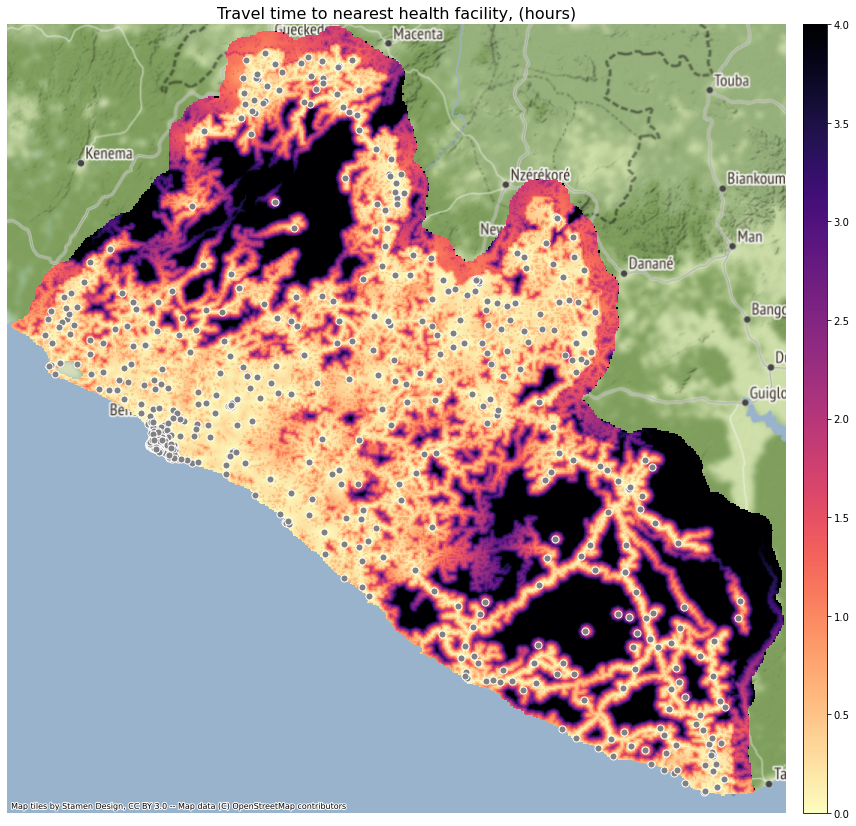

In [54]:
figsize = (12,12)
fig, ax = plt.subplots(1, 1,  figsize = figsize)
ax.set_title("Travel time to nearest health facility, (hours)", fontsize=16)
plt.axis('off')


ext = plotting_extent(tt_health_rio)
# res_gdf_tt.plot('tt_health', ax = ax, categorical=False, legend=True, vmin=0, vmax=30, cmap='magma_r')
im = ax.imshow(tt_health, cmap='magma_r', extent=ext, vmin=0, vmax=4) # norm=colors.PowerNorm(gamma=0.3)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="3%", pad=0.25)
cb = fig.colorbar(im, cax=cax, orientation="vertical")
# cb.set_label('Population at Risk')

lbr_geo_filt.plot(ax=ax, facecolor='gray', edgecolor='white', markersize=50, alpha=1)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)

plt.tight_layout()
plt.savefig(os.path.join(out_folder, "Friction_TT_health.png"), dpi=300, bbox_inches='tight', facecolor='white')

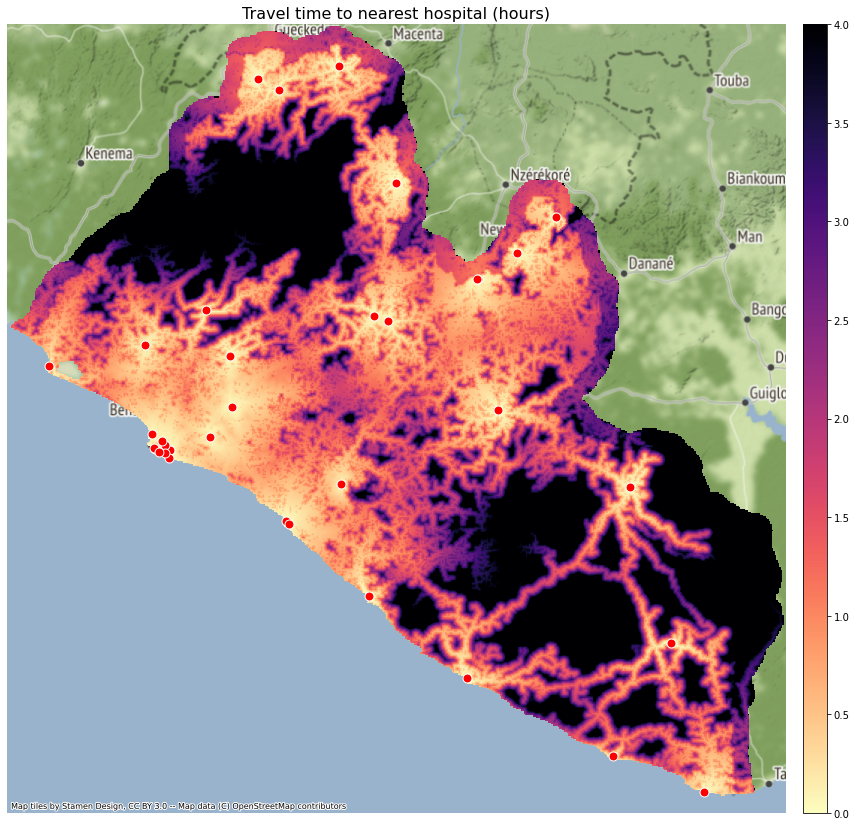

In [55]:
figsize = (12,12)
fig, ax = plt.subplots(1, 1,  figsize = figsize)
ax.set_title("Travel time to nearest hospital (hours)", fontsize=16)
plt.axis('off')


ext = plotting_extent(tt_hospital_rio)
# res_gdf_tt.plot('tt_health', ax = ax, categorical=False, legend=True, vmin=0, vmax=30, cmap='magma_r')
im = ax.imshow(tt_hospital, cmap='magma_r', extent=ext, vmin=0, vmax=4) # norm=colors.PowerNorm(gamma=0.3)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="3%", pad=0.25)
cb = fig.colorbar(im, cax=cax, orientation="vertical")
# cb.set_label('Population at Risk')

hospitals.plot(ax=ax, facecolor='red', edgecolor='white', markersize=80, alpha=1)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)

plt.tight_layout()
plt.savefig(os.path.join(out_folder, "Friction_TT_hospital.png"), dpi=300, bbox_inches='tight', facecolor='white')